# Homework 07 - Autoencoders

Group 08: Johanna Linkemeyer, Marisa Wodrich

In [27]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import time
from tensorflow.keras import Model

## Dataset

fashion mnist data set
* 60000 train images
* 10000 test_images
* 10 categories
* image size 28 x 28 x 1

In [54]:
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.fashion_mnist.load_data()

In [55]:
print('Train images shape: ', train_images.shape)
print('Test images shape: ', test_images.shape)

print(train_images.dtype)
print(test_images.dtype)

Train images shape:  (60000, 28, 28)
Test images shape:  (10000, 28, 28)
uint8
uint8


take a look at the data (print some examples)

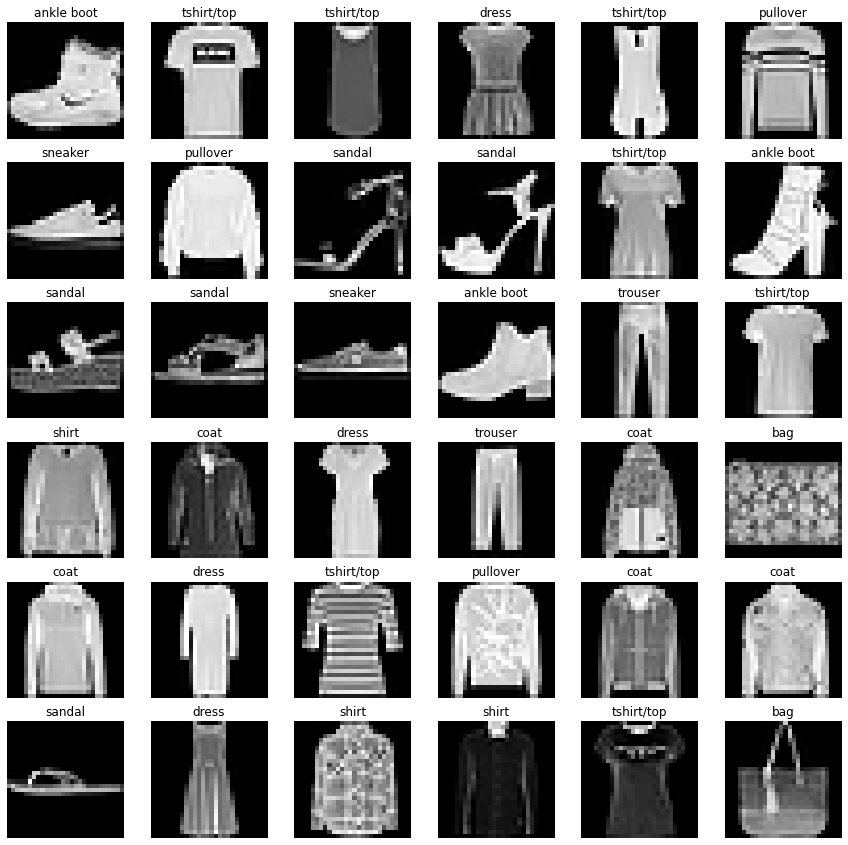

In [56]:
# labels
labels = ['tshirt/top',
          'trouser',
          'pullover',
          'dress',
          'coat',
          'sandal',
          'shirt',
          'sneaker',
          'bag',
          'ankle boot']

# examples per axis
# --> we will print n*n examples
n = 6

_, ax = plt.subplots(n,n, figsize=(15,15))
plt.gray() 

for i in range(n):
  for j in range(n):
    ax[i,j].imshow(train_images[i*n + j])
    ax[i,j].set_title(labels[train_labels[i*n + j]])
    ax[i,j].axis('off')

#### Preprocessing
We will only use the images and not the labels for our model. The labels are only used later for our analysis and therefore do not need to be preprocessed.

In [57]:
# Preprocess training data
train_images = train_images.astype(np.float32)
train_images = tf.expand_dims(train_images, -1)
train_images_prep = tf.data.Dataset.from_tensor_slices(train_images)

# Normalize training images (range [0,1])
train_images_prep = train_images_prep.map(lambda x: x/255)

# Batching, shuffling and prefetching
train_imgs = train_images_prep.shuffle(buffer_size=10000)
train_imgs = train_imgs.batch(64, drop_remainder=True)

# Preprocess testing data
test_images = test_images.astype(np.float32)
test_images = tf.expand_dims(test_images, -1)
test_images_prep = tf.data.Dataset.from_tensor_slices(test_images)

# Normalize test images (range [0,1])
test_images_prep = test_images_prep.map(lambda x : x/255)

# Batching, shuffling and prefetching
test_imgs = test_images_prep.shuffle(buffer_size=10000)
test_imgs = test_imgs.batch(64, drop_remainder=True)

In [58]:
print(train_imgs)
print(test_imgs)

<BatchDataset shapes: (64, 28, 28, 1), types: tf.float32>
<BatchDataset shapes: (64, 28, 28, 1), types: tf.float32>


## Model
We will build an autoencoder model which consists of an encoder and a decoder.

In [59]:
# activation functions
RELU = tf.keras.activations.relu
SIGMOID = tf.keras.activations.sigmoid

# dimension of embeddings
emb_dim = 64
filters = 32

#### Encoder Model

In [60]:
class Encoder(Model):

  def __init__(self, filters):
    """
    Each Convolutional Encoder consists of two convolutional layers, followed 
    by a flatten and finally a dense layer.
    """

    super(Encoder, self).__init__()
    
    self.conv_1 = tf.keras.layers.Conv2D(filters=filters, 
                                         kernel_size=3, 
                                         strides=2, 
                                         activation=RELU, 
                                         padding='same')
    self.conv_2 = tf.keras.layers.Conv2D(filters=filters*2, 
                                         kernel_size=3, 
                                         strides=2, 
                                         activation=RELU, 
                                         padding='same')
    self.flatten = tf.keras.layers.Flatten()
    self.dense = tf.keras.layers.Dense(emb_dim, 
                                       activation=RELU)


  @tf.function
  def call(self, x):
    
    x = self.conv_1(x)
    x = self.conv_2(x)
    x = self.flatten(x)
    x = self.dense(x)

    return x

In [91]:
# Test encoder functionality
inp = tf.zeros((1,28,28,1))

encoder_test = Encoder(filters=filters)
result = encoder_test(inp)

flat_size = 3136

In [92]:
encoder_test.summary()

Model: "encoder_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            multiple                  320       
_________________________________________________________________
conv2d_3 (Conv2D)            multiple                  18496     
_________________________________________________________________
flatten_1 (Flatten)          multiple                  0         
_________________________________________________________________
dense_3 (Dense)              multiple                  200768    
Total params: 219,584
Trainable params: 219,584
Non-trainable params: 0
_________________________________________________________________


#### Decoder Model

In [88]:
class Decoder(Model):

  def __init__(self, filters):
    """
    Each Decoder consists of a dense layer to restore # of units, then reshape 
    and use transposed convolutional layers to restore the original image shape.
    """

    super(Decoder, self).__init__()

    self.dense = tf.keras.layers.Dense(units=(7 * 7 * filters * 2), 
                                       activation=RELU)
    self.shaping = tf.keras.layers.Reshape((7, 7, filters*2))
    self.convT_1 = tf.keras.layers.Conv2DTranspose(filters=filters, 
                                                   kernel_size=(2,2), 
                                                   strides=(2,2), 
                                                   activation=RELU, 
                                                   padding='same')
    self.convT_2 = tf.keras.layers.Conv2DTranspose(filters=1, 
                                                   kernel_size=(2,2), 
                                                   strides=(2,2), 
                                                   padding='same')

  @tf.function
  def call(self, x):
 
    x = self.dense(x)
    x= self.shaping(x)
    x = self.convT_1(x)
    x = self.convT_2(x)

    return x


In [89]:
# Test decoder functionality
inp = tf.zeros((1,64))

decoder_test = Decoder(filters=filters)
result = decoder_test(inp)

In [90]:
decoder_test.summary()

Model: "decoder_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              multiple                  203840    
_________________________________________________________________
reshape_1 (Reshape)          multiple                  0         
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr multiple                  8224      
_________________________________________________________________
conv2d_transpose_3 (Conv2DTr multiple                  129       
Total params: 212,193
Trainable params: 212,193
Non-trainable params: 0
_________________________________________________________________


#### Autoencoder Model

In [93]:
class Autoencoder(Model):

  def __init__(self, filters):
    """
    An Autoencoder consists of stacked Encoder and Decoder that can be 
    initialised with specific number of filters.
    """

    super(Autoencoder, self).__init__()

    self.encoder = Encoder(filters=filters)   
    self.decoder = Decoder(filters=filters)


  @tf.function
  def call(self, x):
    
    x = self.encoder(x)
    x = self.decoder(x)

    return x
    

In [94]:
# Test Autoencoder functionality
inp = tf.zeros((1,28,28,1))

autoencoder_test = Autoencoder(filters=filters)
result = autoencoder_test(inp)

In [95]:
autoencoder_test.summary()

Model: "autoencoder_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_2 (Encoder)          multiple                  219584    
_________________________________________________________________
decoder_2 (Decoder)          multiple                  212193    
Total params: 431,777
Trainable params: 431,777
Non-trainable params: 0
_________________________________________________________________


## Training

In [96]:
def train_step(model, input, target, loss_function, optimizer):
  """
  performs one training step
  model :         our model
  input :         the input that is fed into the model
  target :        true label of input
  loss_function : our loss function
  optimizer :     our optimizer
  """
  with tf.GradientTape() as tape:
    prediction = model(input)
    loss = loss_function(target, prediction)
    accuracy = 1-loss
    gradients = tape.gradient(loss, model.trainable_variables)

  optimizer.apply_gradients(zip(gradients, model.trainable_variables))

  return np.mean(loss), np.mean(accuracy)


def test(model, test_data, loss_function):
  """
  test model over complete test data set
  model :         our model
  test_data :     our test data
  loss_function : our loss function
  """

  test_accuracy_aggregator = []
  test_loss_aggregator = []

  # iterate over the test data set (encode and decode images)
  # also calculate loss and accuracy 
  for idx, input in enumerate(test_data):

    prediction = model(input)
    loss = loss_function(input, prediction)
    accuracy = 1-loss
    test_accuracy_aggregator.append(accuracy)
    test_loss_aggregator.append(loss)

    # from the first batch, print some example images and their prediction
    if idx == 0:
      _, ax = plt.subplots(2, 6, figsize=(15,5))

      for i, img in enumerate(input[:6]):
        ax[0,i].imshow(img.numpy().reshape((28,28)))

      for i, img in enumerate(prediction[:6]):
        ax[1,i].imshow(img.numpy().reshape((28,28)))
        
      plt.show()

  test_loss = np.mean(test_loss_aggregator)
  test_accuracy = np.mean(test_accuracy_aggregator)

  return test_loss, test_accuracy

In [98]:
tf.keras.backend.clear_session()

# Hyperparameters
num_epochs = 10
learning_rate = 0.001
running_average_factor = 0.95

model = Autoencoder(filters=filters)

# Using MSE loss and Adam optimizer
mse_loss = tf.keras.losses.MeanSquaredError()
optimizer = tf.keras.optimizers.Adam(learning_rate)

# Initialize lists for visualization.
train_losses, train_accuracies = [], []
test_losses, test_accuracies = [], []

Epoch: __ 1
Iteration #100 loss: 0.036604177206754684
Iteration #200 loss: 0.023193590342998505
Iteration #300 loss: 0.0186549574136734
Iteration #400 loss: 0.019479304552078247
Iteration #500 loss: 0.01727466657757759
Iteration #600 loss: 0.018256021663546562
Iteration #700 loss: 0.016370221972465515
Iteration #800 loss: 0.015698127448558807
Iteration #900 loss: 0.015566892921924591


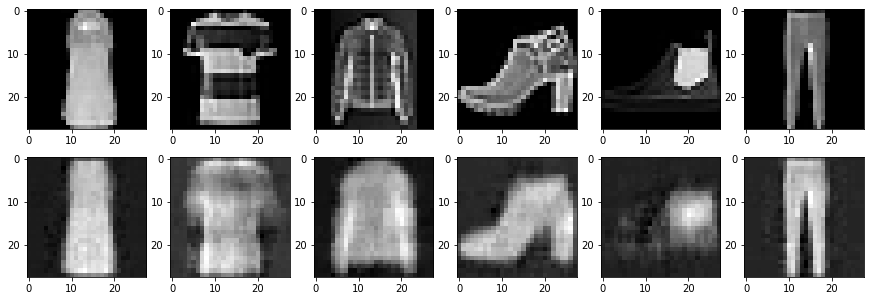

... finished after 12.23 seconds --- Train loss: 0.0155 - Train accuracy: 0.9845 --- Test loss: 0.0155 - Test accuracy: 0.9845 
Epoch: __ 2
Iteration #100 loss: 0.01345186959952116
Iteration #200 loss: 0.014911072328686714
Iteration #300 loss: 0.013074532151222229
Iteration #400 loss: 0.013236374594271183
Iteration #500 loss: 0.01313846092671156
Iteration #600 loss: 0.013963054865598679
Iteration #700 loss: 0.011643601581454277
Iteration #800 loss: 0.014196651056408882
Iteration #900 loss: 0.0153299979865551


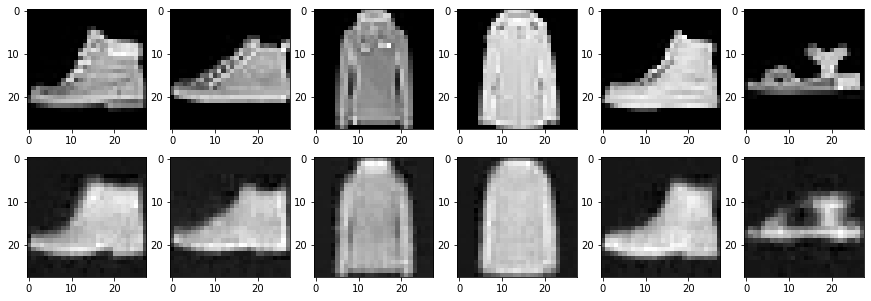

... finished after 11.51 seconds --- Train loss: 0.0134 - Train accuracy: 0.9866 --- Test loss: 0.0133 - Test accuracy: 0.9867 
Epoch: __ 3
Iteration #100 loss: 0.014166785404086113
Iteration #200 loss: 0.012907760217785835
Iteration #300 loss: 0.014284532517194748
Iteration #400 loss: 0.013650807552039623
Iteration #500 loss: 0.013638636097311974
Iteration #600 loss: 0.012085333466529846
Iteration #700 loss: 0.014514942653477192
Iteration #800 loss: 0.013675473630428314
Iteration #900 loss: 0.011711305938661098


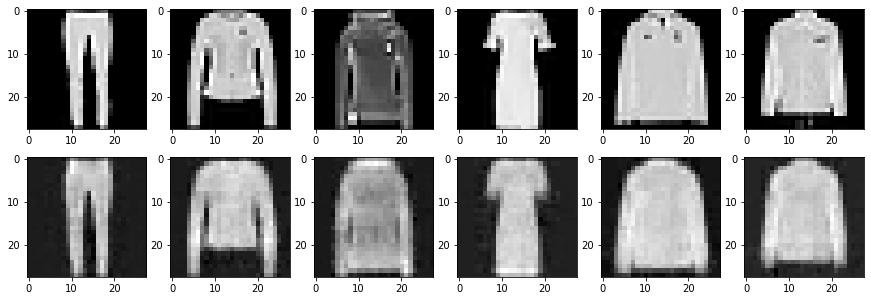

... finished after 11.44 seconds --- Train loss: 0.0124 - Train accuracy: 0.9876 --- Test loss: 0.0124 - Test accuracy: 0.9876 
Epoch: __ 4
Iteration #100 loss: 0.012499641627073288
Iteration #200 loss: 0.010158580727875233
Iteration #300 loss: 0.011622325517237186
Iteration #400 loss: 0.012433611787855625
Iteration #500 loss: 0.012216130271553993
Iteration #600 loss: 0.011881407350301743
Iteration #700 loss: 0.01187206245958805
Iteration #800 loss: 0.01082791481167078
Iteration #900 loss: 0.01281292736530304


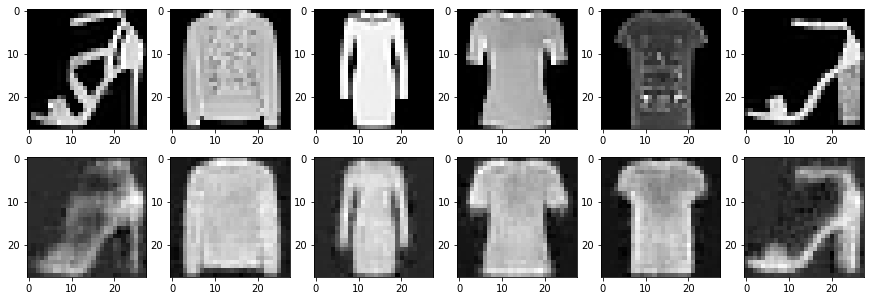

... finished after 11.41 seconds --- Train loss: 0.012 - Train accuracy: 0.988 --- Test loss: 0.0119 - Test accuracy: 0.9881 
Epoch: __ 5
Iteration #100 loss: 0.012638740241527557
Iteration #200 loss: 0.010086934082210064
Iteration #300 loss: 0.011901999823749065
Iteration #400 loss: 0.012032699771225452
Iteration #500 loss: 0.010918457061052322
Iteration #600 loss: 0.010720174759626389
Iteration #700 loss: 0.011886408552527428
Iteration #800 loss: 0.011095920577645302
Iteration #900 loss: 0.010494129732251167


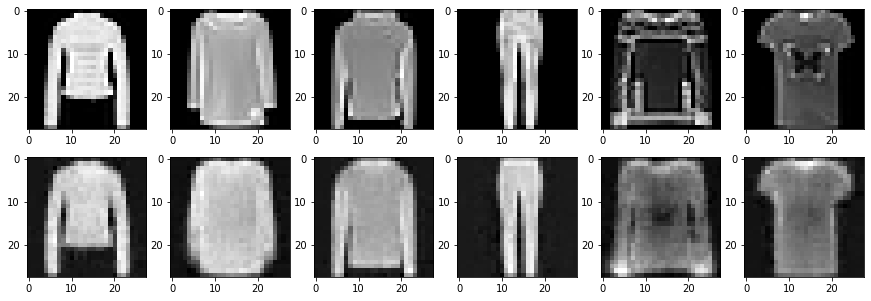

... finished after 11.53 seconds --- Train loss: 0.0111 - Train accuracy: 0.9889 --- Test loss: 0.0114 - Test accuracy: 0.9886 
Epoch: __ 6
Iteration #100 loss: 0.010689416900277138
Iteration #200 loss: 0.012343731708824635
Iteration #300 loss: 0.010227289982140064
Iteration #400 loss: 0.01148773729801178
Iteration #500 loss: 0.010989670641720295
Iteration #600 loss: 0.011844925582408905
Iteration #700 loss: 0.012178746983408928
Iteration #800 loss: 0.01145669911056757
Iteration #900 loss: 0.010264224372804165


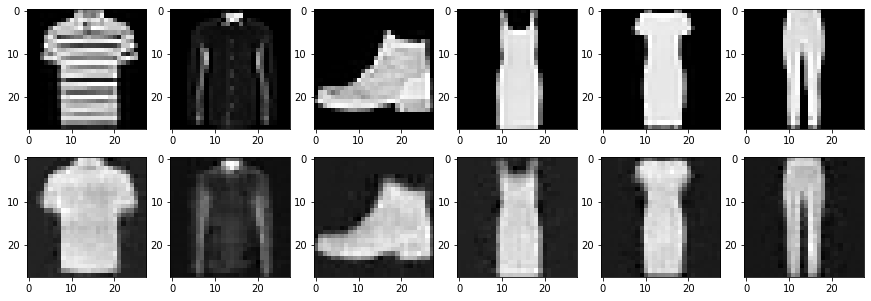

... finished after 11.35 seconds --- Train loss: 0.0113 - Train accuracy: 0.9887 --- Test loss: 0.0112 - Test accuracy: 0.9888 
Epoch: __ 7
Iteration #100 loss: 0.01227606926113367
Iteration #200 loss: 0.00982648879289627
Iteration #300 loss: 0.011621586047112942
Iteration #400 loss: 0.011332721449434757
Iteration #500 loss: 0.010014455765485764
Iteration #600 loss: 0.008682302199304104
Iteration #700 loss: 0.012600448913872242
Iteration #800 loss: 0.013198022730648518
Iteration #900 loss: 0.010427058674395084


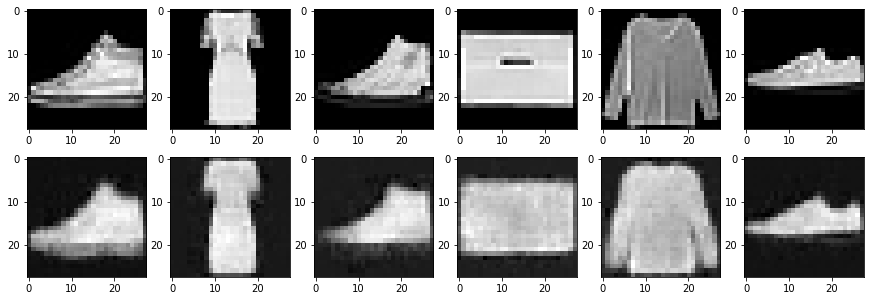

... finished after 11.43 seconds --- Train loss: 0.0109 - Train accuracy: 0.9891 --- Test loss: 0.011 - Test accuracy: 0.989 
Epoch: __ 8
Iteration #100 loss: 0.010383338667452335
Iteration #200 loss: 0.01035562064498663
Iteration #300 loss: 0.009509417228400707
Iteration #400 loss: 0.010911604389548302
Iteration #500 loss: 0.011646107770502567
Iteration #600 loss: 0.009273043833673
Iteration #700 loss: 0.00954519771039486
Iteration #800 loss: 0.01010100357234478
Iteration #900 loss: 0.010453290306031704


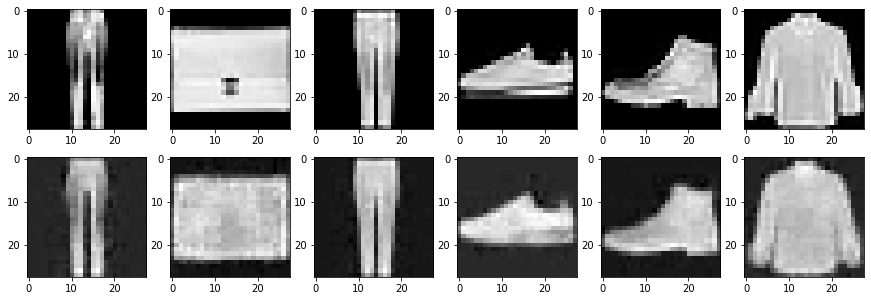

... finished after 11.6 seconds --- Train loss: 0.0109 - Train accuracy: 0.9891 --- Test loss: 0.0109 - Test accuracy: 0.9891 
Epoch: __ 9
Iteration #100 loss: 0.010077918879687786
Iteration #200 loss: 0.009440407156944275
Iteration #300 loss: 0.010380728170275688
Iteration #400 loss: 0.011708260513842106
Iteration #500 loss: 0.01017780601978302
Iteration #600 loss: 0.010475406423211098
Iteration #700 loss: 0.01024476159363985
Iteration #800 loss: 0.00915675237774849
Iteration #900 loss: 0.010831653140485287


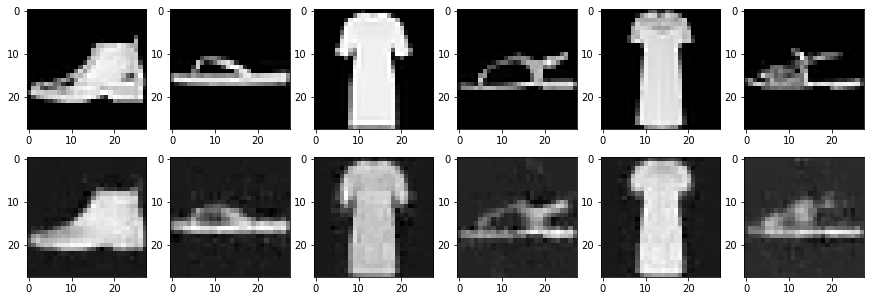

... finished after 11.4 seconds --- Train loss: 0.0107 - Train accuracy: 0.9893 --- Test loss: 0.0106 - Test accuracy: 0.9894 
Epoch: __ 10
Iteration #100 loss: 0.010168098844587803
Iteration #200 loss: 0.00920485332608223
Iteration #300 loss: 0.008835980668663979
Iteration #400 loss: 0.007968428544700146
Iteration #500 loss: 0.010291337966918945
Iteration #600 loss: 0.008855200372636318
Iteration #700 loss: 0.010429656133055687
Iteration #800 loss: 0.010627882555127144
Iteration #900 loss: 0.010860557667911053


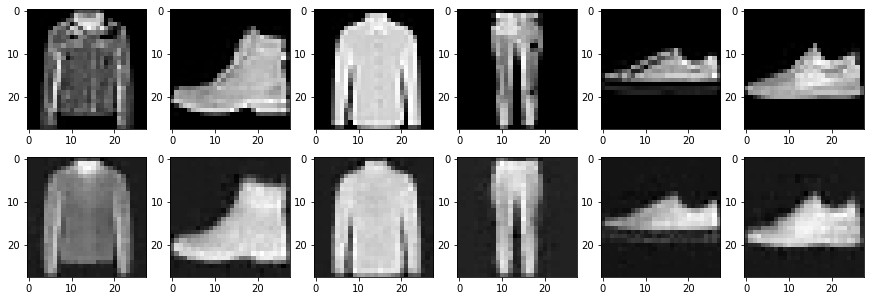

... finished after 11.52 seconds --- Train loss: 0.0103 - Train accuracy: 0.9897 --- Test loss: 0.0104 - Test accuracy: 0.9896 


In [99]:
# We train for num_epochs epochs.
for epoch in range(num_epochs):

  # Track epoch and time while code runs
  start = time.time()
  print('Epoch: __ ' + str(epoch+1))

  #training (and checking in with training)
  running_average_loss = 0
  running_average_accuracy = 0

  for itr, input in enumerate(train_imgs):
    
    train_loss, train_accuracy = train_step(model, input, input, mse_loss, optimizer)
    running_average_loss = running_average_factor * running_average_loss  + (1 - running_average_factor) * train_loss
    running_average_accuracy = running_average_factor * running_average_accuracy  + (1 - running_average_factor) * train_accuracy

    # Keep track of the loss
    if itr % 100 == 0 and itr > 0:
      print(f"Iteration #{itr} loss: {train_loss}")

  train_losses.append(running_average_loss)
  train_accuracies.append(running_average_accuracy)

  #testing
  test_loss, test_accuracy = test(model, test_imgs, mse_loss)
  test_losses.append(test_loss)
  test_accuracies.append(test_accuracy)

  duration = time.time() - start

  # Measure time required for each epoch + show loss and accuracy progress
  print('... finished after %s seconds --- Train loss: %s - Train accuracy: %s --- Test loss: %s - Test accuracy: %s ' % (round(duration, 2), round(running_average_loss, 4), round(running_average_accuracy, 4), round(test_loss, 4), round(test_accuracy, 4)))

## Latent Space Analysis

First we need to prepare our data for this. We will read it in again and create a new dataset.

In [176]:
# load the data
(_, _), (images, labels) = tf.keras.datasets.fashion_mnist.load_data()

# change dtype
images = images.astype(np.float32)

# Preprocessing steps
# DO NOT SHUFFLE 
images = tf.expand_dims(images, -1)
images = tf.data.Dataset.from_tensor_slices(images)
images = images.map(lambda x : x/255)
images = images.batch(1000, drop_remainder=True)

In [177]:
print(images)

<BatchDataset shapes: (1000, 28, 28, 1), types: tf.float32>


In [178]:
# Create embeddings for the first 1000 test images (first batch)
embeddings = []

for input in images:
  
  prediction = model.encoder(input)

  for p in prediction:
    embeddings.append(p.numpy())

  # as we have a batch size of 1000, we just need the first batch
  break


In [181]:
from sklearn.manifold import TSNE

X = np.asarray(embeddings)

X_embedded = TSNE(n_components=2, init='pca').fit_transform(X)

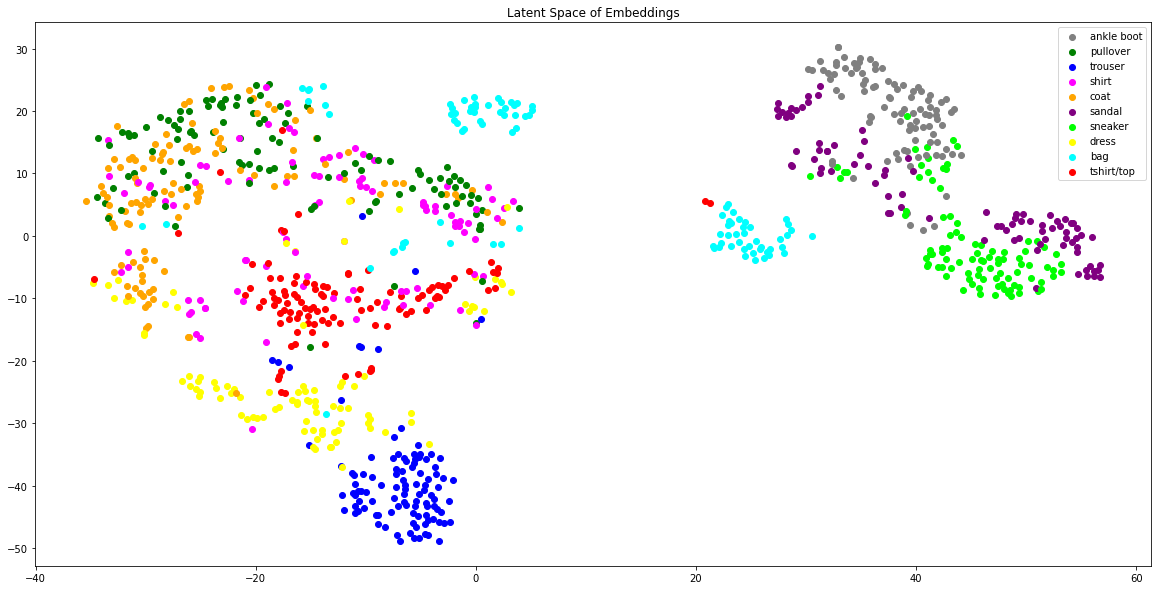

In [174]:
from pylab import rcParams
rcParams['figure.figsize'] = 20, 10

categories = ['tshirt/top',
              'trouser',
              'pullover',
              'dress',
              'coat',
              'sandal',
              'shirt',
              'sneaker',
              'bag',
              'ankle boot']

colors = ['red',
          'blue',
          'green',
          'yellow',
          'orange',
          'purple',
          'magenta',
          'lime',
          'cyan',
          'gray']



for i, emb in enumerate(X_embedded):
  
  ax = plt.scatter(emb[0], emb[1], c=colors[labels[i]], label=categories[labels[i]])


handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())

plt.title('Latent Space of Embeddings')
plt.show()

**Results**: From the 2-dimensional representation of our embeddings we can clearly see that they form clusters. After the model learns appropriate representations for embeddings, clusters should theoretically stand for our different categories. For each categorie, the embeddings should have quite a lot of similarities, while having less similarities with examples from other categories. Looking at the latent space we can make sure that our embeddings still carry enough information about the identity of the images. Here indeed, our models seems to have learned the identity function quite well (of course there is still noise).

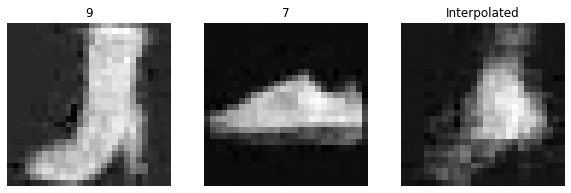

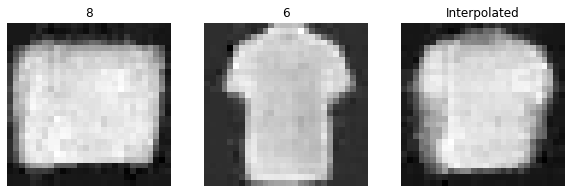

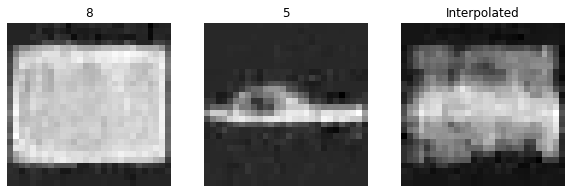

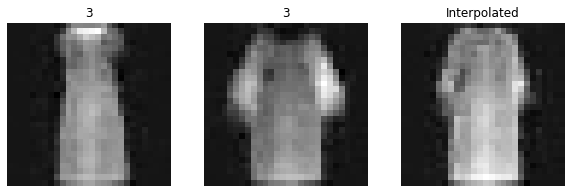

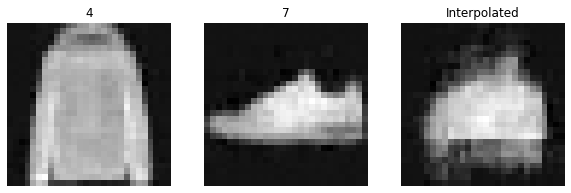

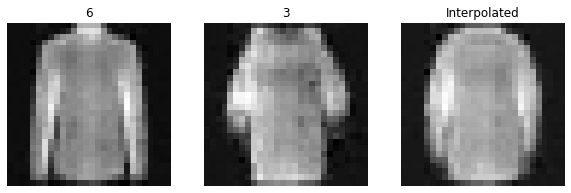

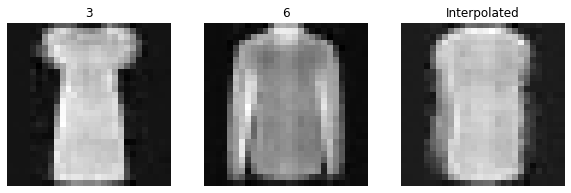

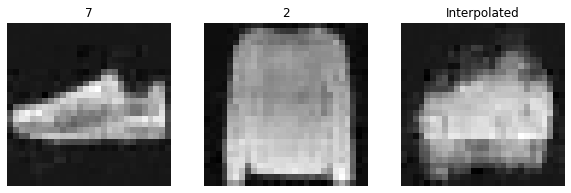

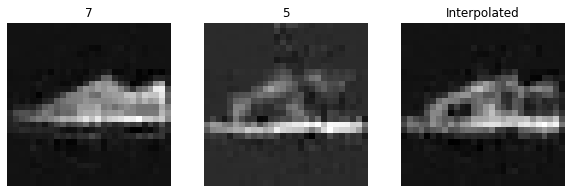

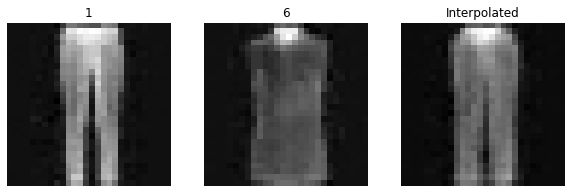

In [183]:

# Create x interpolations between two random images each
x = 10
for _ in range(x):

  # Two random numbers from 0 to 999
  positions = np.random.randint(0, len(embeddings)-1, size=2)

  # Get correct shape for decoder
  img1 = tf.expand_dims(embeddings[positions[0]], 0)
  img2 = tf.expand_dims(embeddings[positions[1]], 0)

  # Interpolate embeddings (img1, img2)
  interpolated = img1 * 0.5 + img2 * 0.5

  # Decode images
  decoded = []
  decoded.append(model.decoder(img1))
  decoded.append(model.decoder(img2))
  decoded.append(model.decoder(interpolated))


  # Plotting
  titles = [labels[positions[0]], labels[positions[1]], 'Interpolated']
  _, ax = plt.subplots(1, 3, figsize=(10,3))
  for i, dec in enumerate(decoded):
    ax[i].imshow(dec.numpy().reshape((28,28)))
    ax[i].set_title(titles[i])
    ax[i].axis('off')

  plt.show()

As for the autoencoder we aim to learn the identity function, the assumption when interpolating the embeddings of two images linearly and decoding the interpolated embedding is that the result after decoding is the linear interpolation of the two original images. This can be seen above.
The idea is that in latent space, the interpolation of two embeddings lays in between the two classes of the images and therefore creates a new 'pseudo-class' where all interpolations of those two classes can be found.